In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("FakeNewsNB").getOrCreate()

data = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiline", "true") \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .load("merged_data.csv")
data.show(5)

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
| Donald Trump Sen...|Donald Trump just...| fake|
| Drunk Bragging T...|House Intelligenc...| fake|
| Sheriff David Cl...|On Friday, it was...| fake|
| Trump Is So Obse...|On Christmas day,...| fake|
| Pope Francis Jus...|Pope Francis used...| fake|
+--------------------+--------------------+-----+
only showing top 5 rows



In [2]:
from pyspark.sql.functions import count

clean_data = data.dropna(subset=["title", "text"])

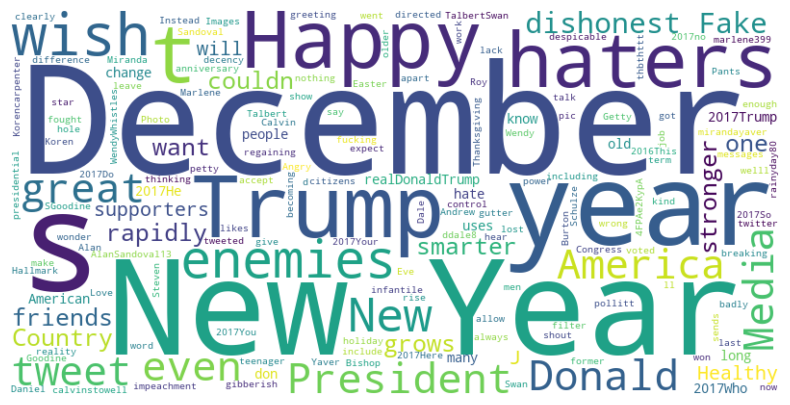

In [3]:
from wordcloud import WordCloud
from pyspark.sql.functions import concat_ws
import matplotlib.pyplot as plt

all_text = clean_data.select(concat_ws(" ", "text")).collect()[0][0]

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

C:\Users\radit\AppData\Local\Temp\ipykernel_10912\3932191027.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=label_counts_pd, palette='viridis')


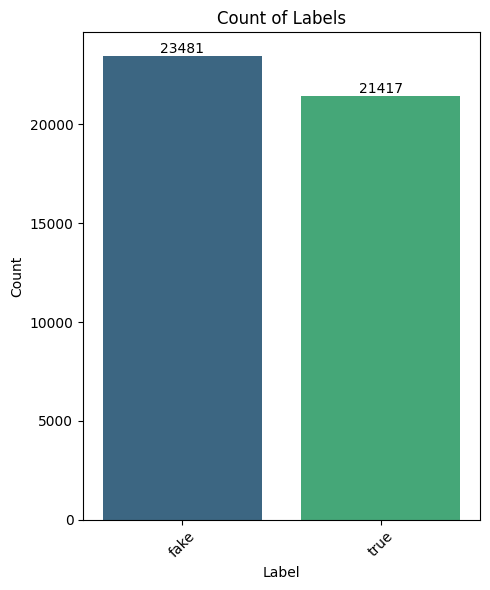

In [4]:
from pyspark.sql.functions import count
import seaborn as sns

label_counts = clean_data.groupBy("label").agg(count("label").alias("count"))

# Convert to Pandas DataFrame
label_counts_pd = label_counts.toPandas()

# Plotting the counts
plt.figure(figsize=(5, 6))
sns.barplot(x='label', y='count', data=label_counts_pd, palette='viridis')
plt.title('Count of Labels')
for index, row in label_counts_pd.iterrows():
    plt.text(index, row['count'], round(row['count'], 2), 
             color='black', ha='center', va='bottom')

plt.title('Count of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [5]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.feature import StringIndexer

# Tokenize
tokenizer = Tokenizer(inputCol="text", outputCol="words")
data = tokenizer.transform(clean_data)

# Stop Words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
data = remover.transform(data)

# Vectorize
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
data = vectorizer.fit(data).transform(data)

# Label Index
indexer = StringIndexer(inputCol="label", outputCol="label_index")
data = indexer.fit(data).transform(data)

data.select("title", "text", "features", "label_index").show(5)

+--------------------+--------------------+--------------------+-----------+
|               title|                text|            features|label_index|
+--------------------+--------------------+--------------------+-----------+
| Donald Trump Sen...|Donald Trump just...|(262144,[0,1,4,5,...|        0.0|
| Drunk Bragging T...|House Intelligenc...|(262144,[0,1,2,4,...|        0.0|
| Sheriff David Cl...|On Friday, it was...|(262144,[0,1,5,6,...|        0.0|
| Trump Is So Obse...|On Christmas day,...|(262144,[0,1,4,5,...|        0.0|
| Pope Francis Jus...|Pope Francis used...|(262144,[0,1,2,6,...|        0.0|
+--------------------+--------------------+--------------------+-----------+
only showing top 5 rows



In [6]:
# Split Data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

In [7]:
from pyspark.sql.functions import col

# Train/Test Label Distribution
label_counts_train = train_data.groupBy("label_index").count().orderBy("label_index")
label_counts_test = test_data.groupBy("label_index").count().orderBy("label_index")

# Show the label distribution
print('Train data')
label_counts_train.show()

print('Test data')
label_counts_test.show()

total = train_data.count()
label_percentages = label_counts.withColumn("percentage", col("count") / total * 100)
label_percentages.show()

Train data
+-----------+-----+
|label_index|count|
+-----------+-----+
|        0.0|18738|
|        1.0|17112|
+-----------+-----+

Test data
+-----------+-----+
|label_index|count|
+-----------+-----+
|        0.0| 4743|
|        1.0| 4305|
+-----------+-----+

+-----+-----+-----------------+
|label|count|       percentage|
+-----+-----+-----------------+
| fake|23481|65.49790794979079|
| true|21417|59.74058577405857|
+-----+-----+-----------------+



In [9]:
# Naive Bayes
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol="features", labelCol="label_index")
nb_model = nb.fit(train_data)

In [10]:
# Evaluate
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = nb_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9833112290008842


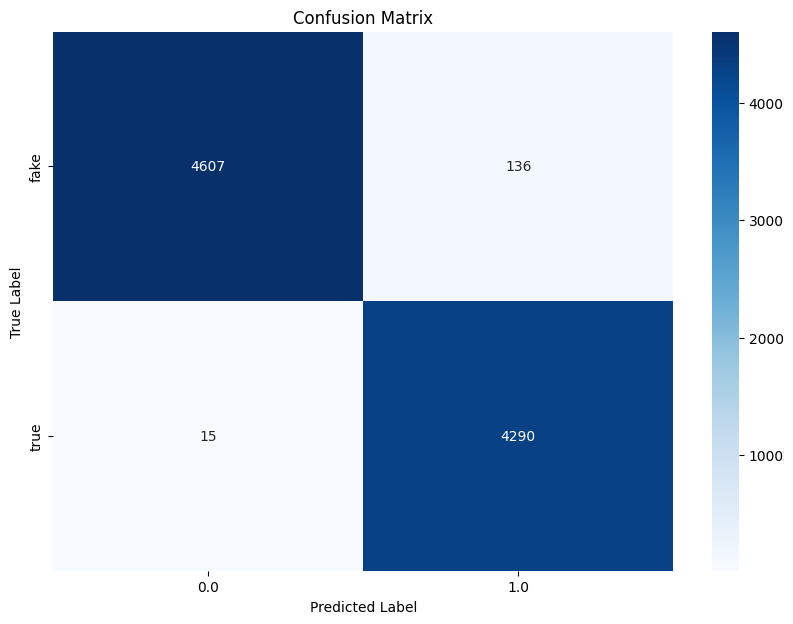

In [11]:
# Confusion Matrix
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = predictions.groupBy("label", "prediction").count()
confusion_matrix_pd = confusion_matrix.toPandas()
confusion_matrix_pivot = confusion_matrix_pd.pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt=".0f", cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()